In [111]:
import GAN.models as models
import ganja.io as io
import ganja.utils as utils
import ganja.plotting as plotting
import ganja.preprocessing as preprocessing

import json

In [112]:
from  keras.models import load_model

In [306]:
target = 'log/baseline_unnorm_cond_noise_sloss_x2/'
with open(target+'/config.json') as fin:
    training_parameters = json.loads(fin.read())
    
globals().update(training_parameters)

training_parameters

{'BASE_FOLDER': '/scratch/snx3000/musella/ganja/split',
 'BATCH': True,
 'BATCH_SIZE': 256,
 'COMPRESSED': False,
 'COND_VARIABLES': ['ptGen', 'etaGen', 'phiGen', 'nPU'],
 'DECODING_LAST_PLATEAU': 2,
 'EPOCHS': 20,
 'IMG_SIZE': 32,
 'MAX_ENCODING': 16,
 'MOMENTS': 'moments_nov2.npz',
 'MONITOR_DIR': 'log/baseline_unnorm_cond_noise_sloss_x2',
 'NFILTERS': 16,
 'NOISE_DIM': 32,
 'NTRAIN': 4,
 'NVALID': 1,
 'N_ENCODING': 6,
 'STDEV_REGULARZATION': 0.02,
 'VALID_FRAC': 2,
 'VERSION': 'nov2_v3',
 'WEIGHTS': 'weights_nov2_pt.npy',
 'WIN_MIN': 0}

In [307]:
import os

with open(BASE_FOLDER+'/'+VERSION+'/train_valid_test.json') as fin:
    split_map = json.loads(fin.read())


In [308]:
test_inputs = {os.path.join(BASE_FOLDER,VERSION) : split_map['test'][:1]}

moments = np.load(MOMENTS.format(VERSION=VERSION))
reco_moments = moments['reco_mean'],moments['reco_std'],0.02
gen_moments = moments['gen_mean'],moments['gen_std'],0.02

weights = np.load(WEIGHTS.format(VERSION=VERSION),encoding='latin1')
weights = weights[0],weights[2:],weights[1]

In [309]:

test_reader = io.Reader(test_inputs,weights,compressed=COMPRESSED,cond_names=COND_VARIABLES,noise_dim=NOISE_DIM)#,gen_moments=gen_moments)


In [310]:
ret = test_reader.get()
X_test,y_test = ret[0:2]
w_test = ret.pop(-1)

inputs_test = [X_test[:,:32,:32]]+ret[2:]

#X_unnorm = preprocessing.unnormalize(X_test,*gen_moments)
X_unnorm = X_test

In [311]:
previous = None

In [313]:
weights = ! ls -t $target/*.hdf5
print("\n".join(weights))

latest = weights[0]

log/baseline_unnorm_cond_noise_sloss_x2//model-00.hdf5


In [314]:
import keras.backend as K
def stratified_mean_squared_error(y_true,y_pred):
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    mask = K.cast(K.greater(y_true,0),K.floatx())
    # print(mask)
    absdiff = K.abs(y_pred-y_true)
    # print(absdiff)
    loss1 = K.sum(mask*absdiff) / K.sum(mask)
    # print(loss1)
    loss0 = K.sum( (1.-mask)*absdiff ) / K.sum(1.-mask)
    # print(loss0)
    return loss0+loss1


if latest != previous:
    print('loading model '+latest)
    model = load_model(latest,custom_objects=dict(stratified_mean_squared_error=stratified_mean_squared_error))
    previous = latest

loading model log/baseline_unnorm_cond_noise_sloss_x2//model-00.hdf5


In [315]:
run_inputs = [ x[:1000] for x in inputs_test ]

y_pred = model.predict(run_inputs)


In [316]:
def show(img,gen,reco,pred):
    # print(row)
    plt.figure(figsize=(10,10))
    plt.subplot(331)
    plt.title("gen")# (pt,eta) = (%1.2g,%1.2g)" % (row.ptGen,row.etaGen) )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow(gen[img,:,:,0],cmap='Reds')
    plt.colorbar()
    plt.subplot(332)
    plt.title("reco")# (pt,eta) = (%1.2g,%1.2g)" % (row.pt,row.eta) )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow(reco[img,:,:,0],cmap='Reds')
    plt.colorbar()
    plt.subplot(333)
    plt.title("pred")# (pt,eta) = (%1.2g,%1.2g)" % (row.pt,row.eta) )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow(pred[img,:,:,0],cmap='Reds')
    plt.colorbar()
    plt.subplot(323)
    mask = (gen[img,:,:,0]>0)
    print(gen[img,:,:,0].min())
    print(mask.any(),(~mask).any())
    plt.title("pred -gen (gen=0)") # reco-true (GeV/area)" )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow( (pred[img,:,:,0]-gen[img,:,:,0])*(~mask),cmap='Blues')
    plt.colorbar()
    plt.subplot(324)
    plt.title("pred -gen (gen!=0)") # reco-true (GeV/area)" )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow( (pred[img,:,:,0]-gen[img,:,:,0])*(mask),cmap='Blues')
    plt.colorbar()
    plt.subplot(325)
    plt.title("pred -reco (gen=0)") # reco-true (GeV/area)" )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow( (pred[img,:,:,0]-reco[img,:,:,0])*(~mask),cmap='Greens')
    plt.colorbar()
    plt.subplot(326)
    plt.title("pred -reco (gen!=0)") # reco-true (GeV/area)" )
    plt.xlabel('$i\eta$')
    plt.ylabel('$i\phi$')    
    plt.imshow( (pred[img,:,:,0]-reco[img,:,:,0])*(mask),cmap='Greens')
    plt.colorbar()
    plt.show()

451
0.0
True True


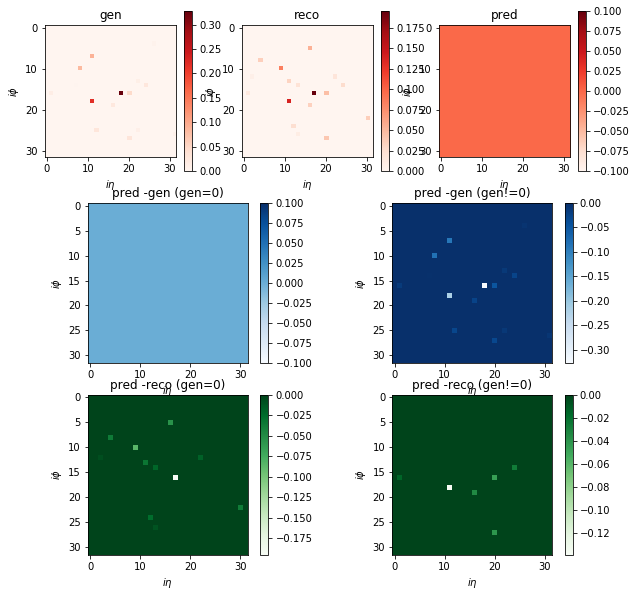

433
0.0
True True


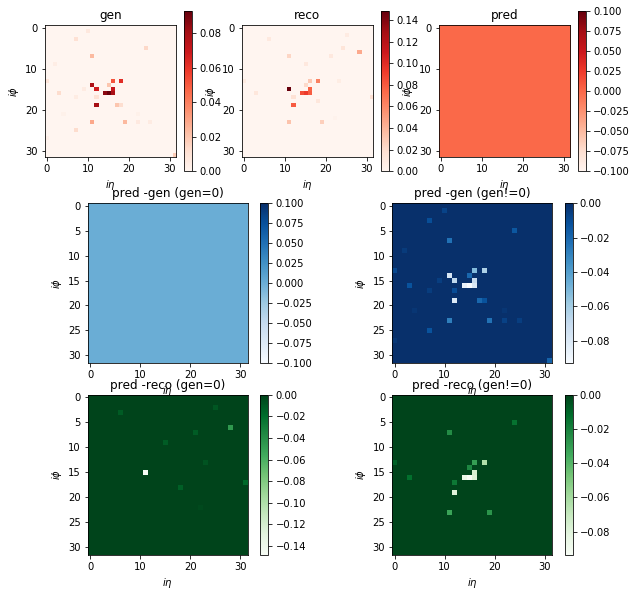

6
0.0
True True


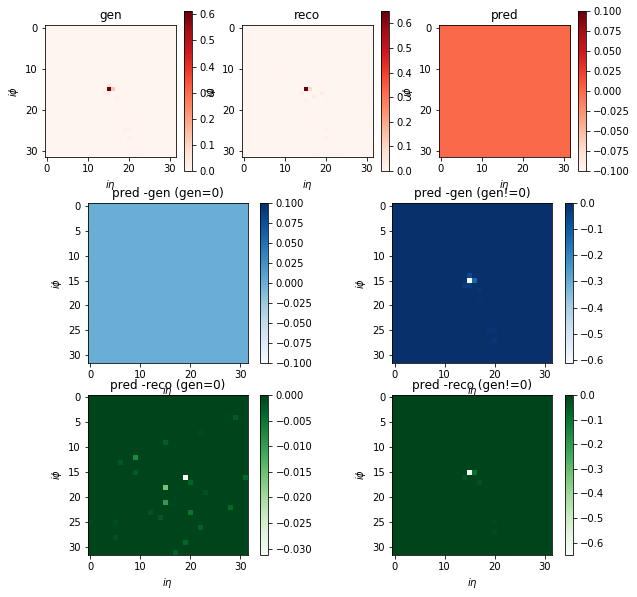

879
0.0
True True


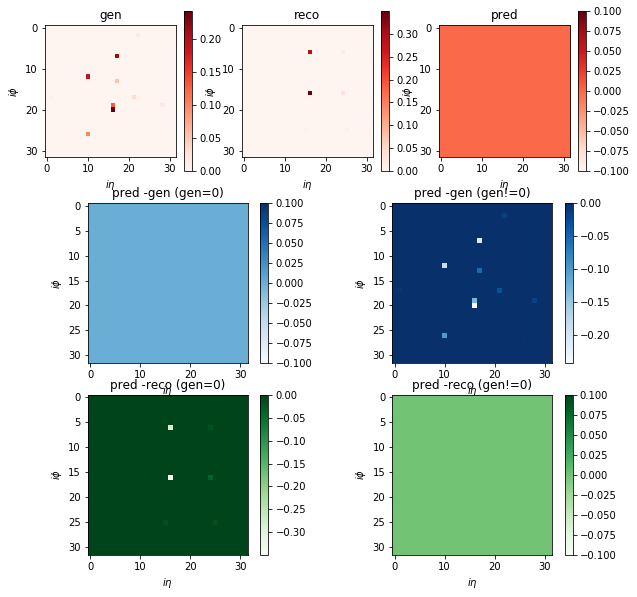

In [317]:
for img in np.random.choice(np.arange(0,y_pred.shape[0]),4):
    print(img)
    show(img,X_unnorm[:,:32,:32],y_test[:,:32,:32],y_pred)

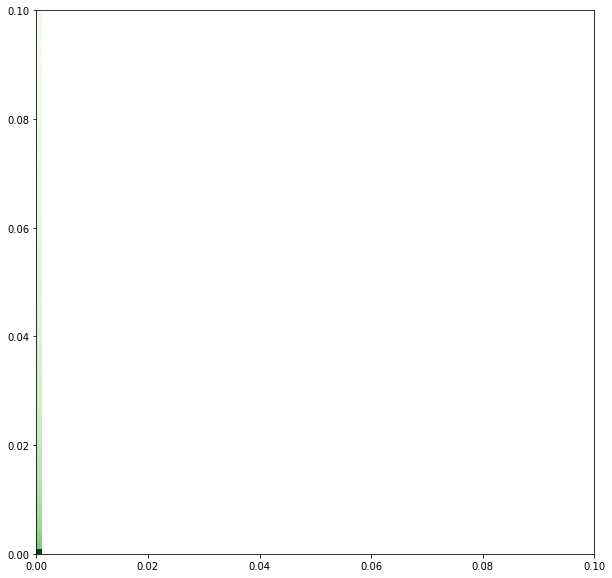

In [318]:
from matplotlib.colors import LogNorm 

plt.hist2d(  y_pred.ravel(), y_test[:y_pred.shape[0],:32,:32].ravel(), range=[ [0,0.1], [0,0.1]], bins=100, norm=LogNorm(), cmap='Greens' );

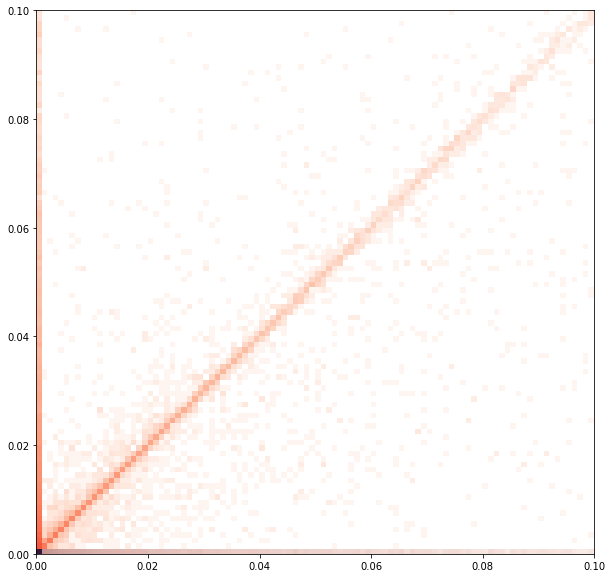

In [319]:
from matplotlib.colors import LogNorm 

plt.hist2d(  X_test[:y_pred.shape[0],:32,:32].ravel(), y_test[:y_pred.shape[0],:32,:32].ravel(), range=[ [0,0.1], [0,0.1]], bins=100, norm=LogNorm(), cmap='Reds' );
plt.hist2d(  X_test[:y_pred.shape[0],:32,:32].ravel(), y_pred.ravel(), range=[ [0,0.1], [0,0.1]], bins=100, norm=LogNorm(), cmap='Blues', alpha=0.5 );


In [170]:
# mask=(np.sum(X_test[:100,11::21,11:21,],axis=(1,2)) == 0.)
# mask[0]

In [217]:
# mask = (X_test[:,11:21,11:21,:].sum(axis=(1,2)) == 0.).ravel()

In [218]:
# X_masked = X_test[mask]
# c_masked = ret[3][mask]
# for jet in np.random.choice(np.arange(X_masked.shape[0]),10):
#     pt,eta = c_masked[jet,0,0:2]
#     plt.imshow(X_masked[jet,:32,:32,0],cmap='Blues')
#     plt.title('Jet image $p_T^i / p_T^{jet}$    $p_T = %1.2f$    $\eta = %1.2f$' % (pt,eta))
#     plt.xlabel('$i\eta$')
#     plt.ylabel('$i\phi$')
#     plt.colorbar()
#     plt.savefig('jet_hole%d.png' % jet)
#     plt.show()

In [219]:
# np.sum(X_test[:100,11::21,11:21,],axis=(1,2)).any(axis=1).shape

In [220]:
# np.sum(X_test[1,11::21,11:21,:],axis=(1,2))

In [221]:
# mask.sum()

In [222]:
# mask.sum() / mask.shape[0]

In [223]:
# COND_VARIABLES

In [234]:
# from matplotlib.colors import LogNorm 

# plt.hist2d(  np.abs(y_pred[:,11:21,11:21].ravel() - y_test[:y_pred.shape[0],11:21,11:21].ravel()), 
#            y_test[:y_pred.shape[0],11:21,11:21].ravel(), range=[ [0,0.1], [0,0.1]], bins=100, norm=LogNorm(), cmap='Greens' );